# Part 2: Model Training & Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split

# Load and prepare data
df = pd.read_csv("eu_sdg_performance_data.csv")

id_like = {"Country", "year", "performance_tier", "sdgi_score"}
feature_cols = [c for c in df.columns if c not in id_like]

X = df[feature_cols]
y = df["performance_tier"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# Define models & train

# Logistic Regression pipeline
log_reg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, random_state=42))
])

# Random Forest
rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample", random_state=42))
])

models = {
    "LogisticRegression": log_reg_pipe,
    "RandomForest": rf_pipe
}

results = []
per_class_metrics = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
    avg_conf = np.mean(np.max(y_proba, axis=1))

    results.append({
        "model": name,
        "accuracy": acc,
        "macro_precision": prec,
        "macro_recall": rec,
        "macro_f1": f1,
        "avg_confidence": avg_conf
    })

    # Per-class metrics
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    for cls in sorted(y.unique()):
        per_class_metrics.append({
            "model": name,
            "tier": cls,
            "precision": report[str(cls)]["precision"],
            "recall": report[str(cls)]["recall"],
            "f1": report[str(cls)]["f1-score"],
            "support": report[str(cls)]["support"]
        })

In [4]:
# Results summary
comp_df = pd.DataFrame(results)
per_class_df = pd.DataFrame(per_class_metrics)

print("=== Model Comparison ===")
print(comp_df.round(3))
print("\n=== Per-Class Metrics ===")
print(per_class_df.round(3))

=== Model Comparison ===
                model  accuracy  macro_precision  macro_recall  macro_f1  \
0  LogisticRegression     0.929            0.967         0.850     0.895   
1        RandomForest     0.976            0.988         0.953     0.969   

   avg_confidence  
0           0.895  
1           0.917  

=== Per-Class Metrics ===
                model  tier  precision  recall     f1  support
0  LogisticRegression     0      1.000   0.882  0.938     17.0
1  LogisticRegression     1      0.902   1.000  0.948     55.0
2  LogisticRegression     2      1.000   0.667  0.800     12.0
3        RandomForest     0      1.000   0.941  0.970     17.0
4        RandomForest     1      0.965   1.000  0.982     55.0
5        RandomForest     2      1.000   0.917  0.957     12.0


RandomForest wins on every metric.

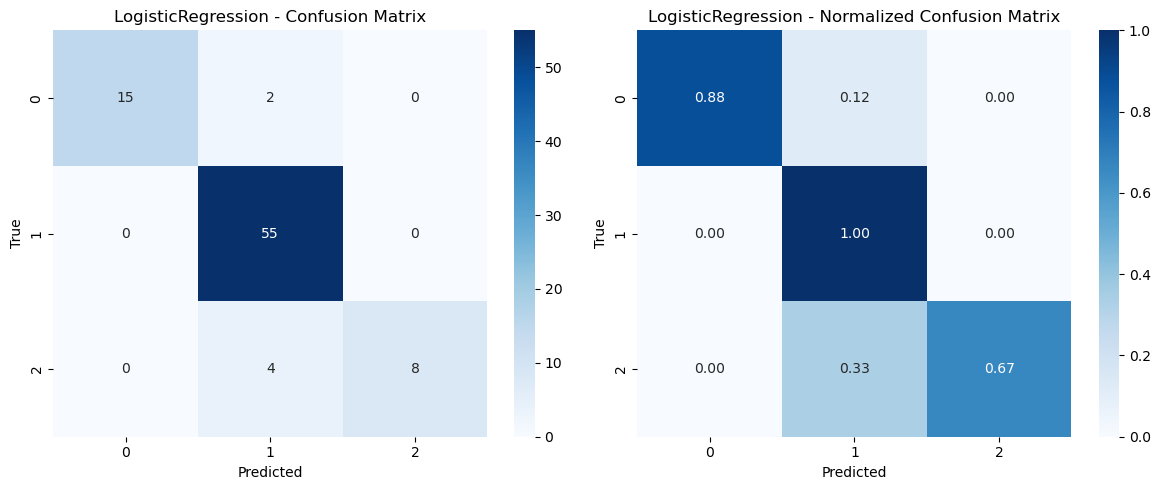

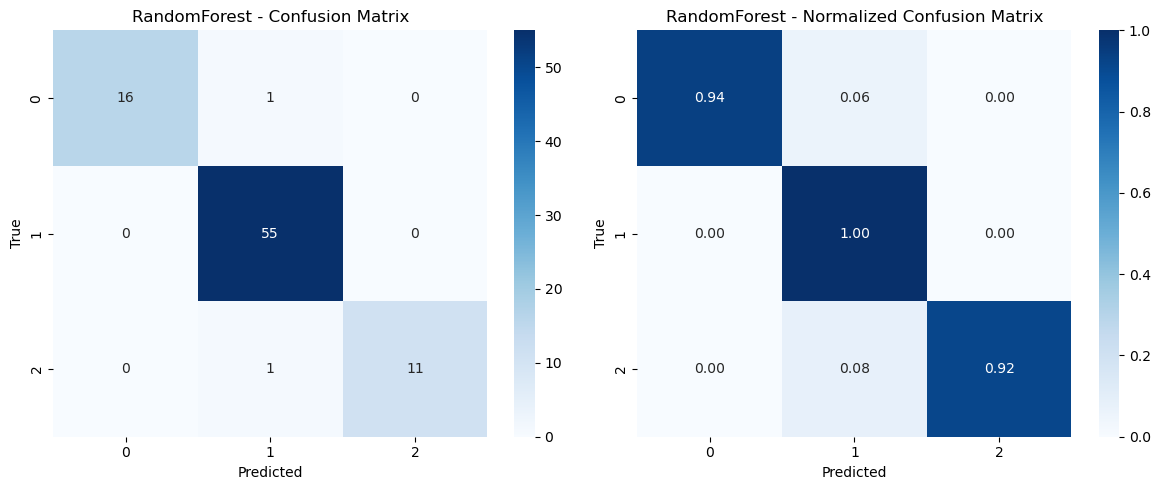

In [5]:
# Confusion matrices
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm, annot=True, fmt="d", ax=ax[0], cmap="Blues")
    ax[0].set_title(f"{name} - Confusion Matrix")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("True")

    sns.heatmap(cmn, annot=True, fmt=".2f", ax=ax[1], cmap="Blues")
    ax[1].set_title(f"{name} - Normalized Confusion Matrix")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("True")

    plt.tight_layout()
    plt.show()

<b>LogisticRegression</b><br>
More confusion for Leaders → Good Performers (≈ 33% misclassified).<br>
<b>RandomForest</b><br>
Almost all classes are cleanly separated; minor confusion is Leaders ↔ Good Performers (Leaders recall ≈ 0.92), and small spillover for Needs Improvement → Good Performers (recall ≈ 0.94). Good Performers are classified perfectly (recall 1.00).<br>

In [6]:
# Feature Importance
importance_list = []

# Logistic Regression coefficients
log_coefs = log_reg_pipe.named_steps["clf"].coef_
log_feat_importance = np.mean(np.abs(log_coefs), axis=0)
importance_list.append(pd.DataFrame({
    "feature": feature_cols,
    "importance": log_feat_importance,
    "model": "LogisticRegression"
}))

# Random Forest feature importances
rf_importance = rf_pipe.named_steps["clf"].feature_importances_
importance_list.append(pd.DataFrame({
    "feature": feature_cols,
    "importance": rf_importance,
    "model": "RandomForest"
}))

importance_df = pd.concat(importance_list)
importance_avg = (importance_df.groupby("feature")["importance"]
                  .mean().sort_values(ascending=False).reset_index())

print("\n=== Top 10 Predictive Features ===")
print(importance_avg.head(10))


=== Top 10 Predictive Features ===
         feature  importance
0   sdg9_digital    0.643659
1      sdg16_cpi    0.593170
2  sdg4_tertiary    0.477300
3   sdg7_eurenew    0.422870
4      sdg16_rsf    0.414945
5     sdg10_gini    0.407400
6      sdg9_eurd    0.401184
7    sdg8_income    0.391119
8    sdg16_crime    0.318955
9    sdg5_empgap    0.315491


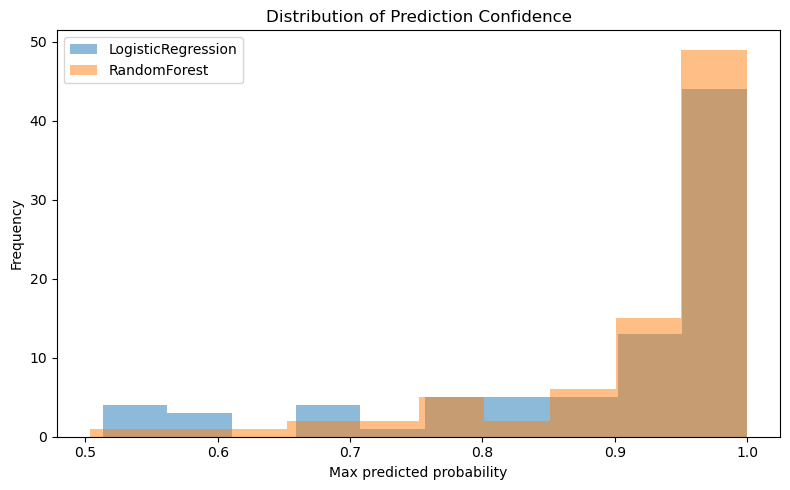


=== Prediction Confidence Summary ===
                model  mean_conf  median_conf  p25_conf  p75_conf
0  LogisticRegression      0.895        0.953     0.836     0.992
1        RandomForest      0.917        0.958     0.913     0.981


In [7]:
summary_rows = []

plt.figure(figsize=(8,5))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)
    max_proba = np.max(y_proba, axis=1)   # confidence per sample
    
    # Plot histogram
    plt.hist(max_proba, bins=10, alpha=0.5, label=name)
    
    # Collect summary statistics
    summary_rows.append({
        "model": name,
        "mean_conf": np.mean(max_proba),
        "median_conf": np.median(max_proba),
        "p25_conf": np.percentile(max_proba, 25),
        "p75_conf": np.percentile(max_proba, 75)
    })

plt.title("Distribution of Prediction Confidence")
plt.xlabel("Max predicted probability")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Build summary table
conf_summary = pd.DataFrame(summary_rows)
print("\n=== Prediction Confidence Summary ===")
print(conf_summary.round(3))